<a href="https://colab.research.google.com/github/Chun1225/Chun1225/blob/main/RP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install pyg-lib using the recommended method from the error message
# This ensures compatibility with your installed PyTorch and CUDA versions
import torch

# Detect PyTorch and CUDA version
TORCH_VERSION = torch.__version__.split('+')[0]
CUDA_VERSION = torch.version.cuda

if CUDA_VERSION:
    # Format as e.g. 'cu118' or 'cu121'
    CUDA_str = f"cu{CUDA_VERSION.replace('.', '')}"
else:
    # If no CUDA, use cpu version
    CUDA_str = 'cpu'

print(f"Detected PyTorch version: {TORCH_VERSION}")
print(f"Detected CUDA version label: {CUDA_str}")

# Construct and execute the correct installation command
# !pip is the syntax to run shell commands in Jupyter/Colab environments
!pip install pyg-lib -f https://data.pyg.org/whl/torch-{TORCH_VERSION}+{CUDA_str}.html

print("\n✅ pyg-lib installation command executed.")

Detected PyTorch version: 2.6.0
Detected CUDA version label: cu124
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 94.4 MB/s eta 0:00:00

✅ pyg-lib installation command executed.


In [ ]:
pip install category_encoders catboost dataframe_image Selenium torch_geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 132.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.7/385.7 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 MB 52.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import time
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi
from IPython.display import display, Image

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, average_precision_score, precision_recall_curve

import category_encoders as ce

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import torch
from torch_geometric.data import HeteroData
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv, Linear, BatchNorm, GATv2Conv
from torch_geometric.loader import LinkNeighborLoader
from tqdm.auto import tqdm

In [ ]:
TRANSACTIONS_PATH = '/content/drive/MyDrive/credit_card_transactions-ibm_v2.csv'
CARDS_INFO_PATH = '/content/drive/MyDrive/sd254_cards.csv'
USERS_INFO_PATH = '/content/drive/MyDrive/sd254_users.csv'

full_df = pd.read_csv(TRANSACTIONS_PATH)
df_trans = full_df.sample(n=1500000, random_state=335)
df_cards = pd.read_csv(CARDS_INFO_PATH)
df_users = pd.read_csv(USERS_INFO_PATH)

print("merge")

df_trans['Amount'] = df_trans['Amount'].replace({'\$': ''}, regex=True).astype(float)
df_trans['Is Fraud?'] = df_trans['Is Fraud?'].apply(lambda x: 1 if x == 'Yes' else 0)

print("... 正在合併 cards 和 users 的所有資訊 ...")
df_card_owner_profile = pd.merge(
    df_cards,
    df_users,
    on='User',
    how='left'
)

df_full_context = pd.merge(
    df_trans,
    df_card_owner_profile,
    on=['User', 'Card'],
    how='left',
    suffixes=('_trans', '')
)

print("dim:", df_full_context.shape)

display(df_full_context.head())
print("Info: ")
df_full_context.info(verbose=True, show_counts=True)

--- 步驟 1: 加載三份數據 ---
三份數據均載入成功！

--- 步驟 2: 執行多表合併 ---
... 正在合併 cards 和 users 的所有資訊 ...
... 正在將完整的 profile資訊 合併到交易數據中 ...
數據合併成功！

--- 步驟 3: 檢查最終的全景數據表 ---
最終資料維度 (行, 列): (1500000, 44)

最終資料預覽:


,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,...,City,State,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards
0,327,0,2014,1,5,11:58,1.19,Swipe Transaction,-6571010470072147219,Meridian,...,Jackson,MS,39282,32.32,-90.20,"$13,717","$27,967","$50,159",690,2
1,15,3,2019,12,28,09:03,8.92,Chip Transaction,-6769821447064127543,Boise City,...,Boise City,OK,73933,36.73,-102.51,"$11,342","$23,123","$5,079",723,6
2,1462,0,2018,5,31,15:12,65.00,Chip Transaction,520740200116537650,Anaheim,...,Anaheim,CA,92805,33.82,-117.91,"$16,252","$33,137","$40,559",706,2
3,1115,2,2010,5,4,13:24,64.75,Swipe Transaction,-4966329464226570448,Duluth,...,Duluth,MN,55807,46.78,-92.11,"$17,474","$27,772","$14,408",788,4
4,269,3,2009,6,5,12:06,-93.00,Swipe Transaction,2027553650310142703,Lordsburg,...,Lordsburg,NM,88045,32.34,-108.70,"$15,407","$31,414","$42,233",719,4



最終資料基本資訊 (Info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500000 entries, 0 to 1499999
Data columns (total 44 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   User                         1500000 non-null  int64  
 1   Card                         1500000 non-null  int64  
 2   Year                         1500000 non-null  int64  
 3   Month                        1500000 non-null  int64  
 4   Day                          1500000 non-null  int64  
 5   Time                         1500000 non-null  object 
 6   Amount                       1500000 non-null  float64
 7   Use Chip                     1500000 non-null  object 
 8   Merchant Name                1500000 non-null  int64  
 9   Merchant City                1500000 non-null  object 
 10  Merchant State               1332636 non-null  object 
 11  Zip                          1323037 non-null  float64
 12  MCC                     


--- 步驟 4: 正在繪製正負樣本分佈圖 ---


/tmp/ipython-input-2548854103.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Is Fraud?', data=df_full_context, palette=['#66b3ff', '#ff9999'])
/tmp/ipython-input-2548854103.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Non-Fraud (0)', 'Fraud (1)'])


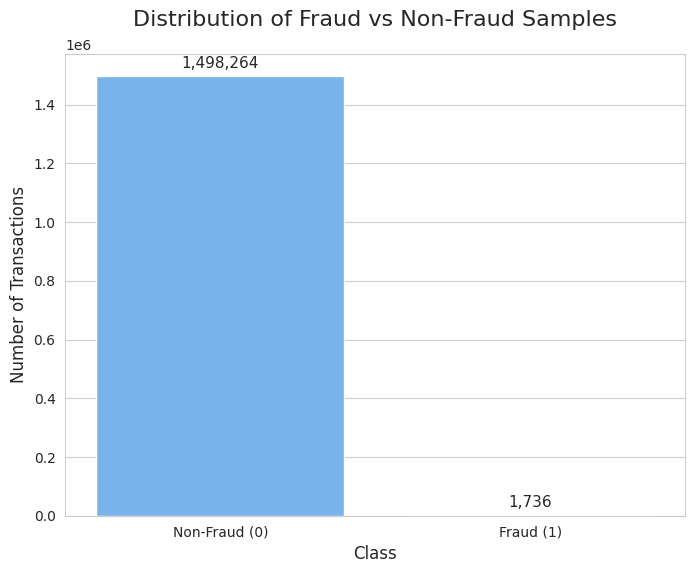

In [ ]:
if 'df_full_context' not in locals():
    print("without df_full_context。")
else:
    sns.set_style("whitegrid")

    plt.figure(figsize=(8, 6))

    ax = sns.countplot(x='Is Fraud?', data=df_full_context, palette=['#66b3ff', '#ff9999'])

    ax.set_title('Distribution of Fraud vs Non-Fraud Samples', fontsize=16, pad=20)
    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel('Number of Transactions', fontsize=12)

    ax.set_xticklabels(['Non-Fraud (0)', 'Fraud (1)'])

    for p in ax.patches:
        ax.annotate(f'{int(p.get_height()):,}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center',
                    va='center',
                    xytext=(0, 9),
                    textcoords='offset points',
                    fontsize=11)

    plt.show()

In [ ]:
def split_composite_errors(error_string: str) -> pd.Series:
    error_string = str(error_string).strip()
    if ',' in error_string:
        parts = error_string.split(',', 1)
        return pd.Series([parts[0].strip(), parts[1].strip()])
    else:
        return pd.Series([error_string, 'None'])

def create_final_feature_set(df: pd.DataFrame) -> pd.DataFrame:

    df_processed = df.copy()

    cols_to_clean_numeric = ['Credit Limit', 'Yearly Income - Person', 'Total Debt', 'Per Capita Income - Zipcode']
    for col in cols_to_clean_numeric:
        if col in df_processed.columns:
            df_processed[col] = pd.to_numeric(df_processed[col].astype(str).str.replace(r'[$,]', '', regex=True), errors='coerce')
    if 'Amount' in df_processed.columns:
        df_processed['Amount'] = df_processed['Amount'].abs()
    id_cols_to_str = ['User', 'Merchant Name', 'Zip', 'MCC', 'Card Brand', 'Card Type', 'Use Chip', 'Has Chip', 'State', 'Merchant State', 'Merchant City', 'City', 'Gender', 'Card on Dark Web']
    for col in id_cols_to_str:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].astype(str)
    if 'Errors?' in df_processed.columns:
        df_processed['Errors?'] = df_processed['Errors?'].fillna('No Error').astype(str)


    if 'User' in df_processed.columns and 'Card' in df_processed.columns:
        df_processed['Card'] = df_processed['User']+ '_' + df_processed['Card'].astype(str)

    if all(c in df_processed.columns for c in ['Year', 'Month', 'Day', 'Time']):
        df_processed['trans_datetime'] = pd.to_datetime(df_processed[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1) + ' ' + df_processed['Time'], errors='coerce')
        df_processed['day_of_week_sin'] = np.sin(2 * np.pi * df_processed['trans_datetime'].dt.dayofweek / 7.0)
        df_processed['day_of_week_cos'] = np.cos(2 * np.pi * df_processed['trans_datetime'].dt.dayofweek / 7.0)
        df_processed['hour_sin'] = np.sin(2 * np.pi * df_processed['trans_datetime'].dt.hour / 24.0)
        df_processed['hour_cos'] = np.cos(2 * np.pi * df_processed['trans_datetime'].dt.hour / 24.0)
        if 'Acct Open Date' in df_processed.columns:
            acct_open_year = pd.to_datetime(df_processed['Acct Open Date'], format='%m/%Y', errors='coerce').dt.year
            df_processed['account_age_at_transaction'] = df_processed['Year'] - acct_open_year
    if 'State' in df_processed.columns and 'Merchant State' in df_processed.columns:
        df_processed['is_in_home_state'] = (df_processed['State'] == df_processed['Merchant State']).astype(int)
    if 'City' in df_processed.columns and 'Merchant City' in df_processed.columns:
        df_processed['is_in_home_city'] = (df_processed['City'] == df_processed['Merchant City']).astype(int)
    if 'Amount' in df_processed.columns and 'Credit Limit' in df_processed.columns:
        df_processed['amount_to_limit_ratio'] = df_processed['Amount'] / df_processed['Credit Limit'].replace(0, 1e-6)
    if 'Amount' in df_processed.columns and 'Yearly Income - Person' in df_processed.columns:
        df_processed['amount_to_personal_income_ratio'] = df_processed['Amount'] / df_processed['Yearly Income - Person'].replace(0, 1e-6)
    if 'Total Debt' in df_processed.columns and 'Yearly Income - Person' in df_processed.columns:
        df_processed['debt_to_income_ratio'] = df_processed['Total Debt'] / df_processed['Yearly Income - Person'].replace(0, 1e-6)
    if 'Amount' in df_processed.columns and 'Per Capita Income - Zipcode' in df_processed.columns:
        df_processed['amount_to_zip_income_ratio'] = df_processed['Amount'] / df_processed['Per Capita Income - Zipcode'].replace(0, 1e-6)
    if 'Errors?' in df_processed.columns:
        df_processed[['Error1', 'Error2']] = df_processed['Errors?'].apply(split_composite_errors)


    final_features_to_keep = [
        'User', 'Card', 'Is Fraud?', 'Amount', 'MCC', 'Card Brand', 'Card Type', 'Has Chip', 'Use Chip',
        'Cards Issued', 'Credit Limit', 'Current Age', 'Gender', 'FICO Score',
        'Num Credit Cards', 'Yearly Income - Person',
        'Merchant Name', 'Merchant State', 'Merchant City', 'State', 'City',
        'Total Debt',
        'Per Capita Income - Zipcode',
        'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos',
        'account_age_at_transaction',
        'is_in_home_state', 'is_in_home_city',
        'amount_to_limit_ratio', 'amount_to_personal_income_ratio',
        'debt_to_income_ratio', 'amount_to_zip_income_ratio',
        'Error1', 'Error2'
    ]

    final_cols_exist = [col for col in final_features_to_keep if col in df_processed.columns]
    df_final = df_processed[final_cols_exist].copy()

    for col in df_final.columns:
        if df_final[col].dtype.name in ['object', 'category']:
            df_final[col] = df_final[col].fillna('Unknown')
        else:
            df_final[col] = df_final[col].fillna(df_final[col].median())

    print(f"dim: {df_final.shape}")
    return df_final

In [ ]:
df_final = create_final_feature_set(df_full_context)

print("info: ")
print(df_final.shape)
df_final.info()


--- 開始執行終極版特徵工程 ---
... 正在清理與轉換數據類型 ...
... 正在創建所有衍生特徵 ...
... 正在選擇最終特徵 ...
... 正在填充剩餘的缺失值 ...
✅ 特徵工程全部完成！最終資料維度: (1500000, 36)

--- 步驟 III: 最終成果檢查 ---
最終 DataFrame 維度: (1500000, 36)

最終 DataFrame 基本資訊:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500000 entries, 0 to 1499999
Data columns (total 36 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   User                             1500000 non-null  object 
 1   Card                             1500000 non-null  object 
 2   Is Fraud?                        1500000 non-null  int64  
 3   Amount                           1500000 non-null  float64
 4   MCC                              1500000 non-null  object 
 5   Card Brand                       1500000 non-null  object 
 6   Card Type                        1500000 non-null  object 
 7   Has Chip                         1500000 non-null  object 
 8   Use Chip                         15000

In [ ]:
print("Cardinality")

categorical_features = df_final.select_dtypes(include=['object']).columns.tolist()

print(f" {len(categorical_features)} Categorical variables：\n")

for col in categorical_features:
    unique_count = df_final[col].nunique()
    print(f"'{col}': {unique_count} unique value")

    if unique_count < 20:
        print(df_final[col].value_counts().to_string())
        print("-" * 30)


   開始分析分類特徵的唯一值數量 (Cardinality Analysis)

共找到 15 個分類特徵。它們的唯一值數量如下：

欄位 'User': 1991 個唯一值
欄位 'Card': 5974 個唯一值
欄位 'MCC': 109 個唯一值
欄位 'Card Brand': 4 個唯一值
  - 具體值與計數:
Card Brand
Mastercard    804381
Visa          552992
Amex           98799
Discover       43828
------------------------------
欄位 'Card Type': 3 個唯一值
  - 具體值與計數:
Card Type
Debit              926205
Credit             472483
Debit (Prepaid)    101312
------------------------------
欄位 'Has Chip': 2 個唯一值
  - 具體值與計數:
Has Chip
YES    1348227
NO      151773
------------------------------
欄位 'Use Chip': 3 個唯一值
  - 具體值與計數:
Use Chip
Swipe Transaction     945695
Chip Transaction      387408
Online Transaction    166897
------------------------------
欄位 'Gender': 2 個唯一值
  - 具體值與計數:
Gender
Female    770910
Male      729090
------------------------------
欄位 'Merchant Name': 39129 個唯一值
欄位 'Merchant State': 191 個唯一值
欄位 'Merchant City': 10255 個唯一值
欄位 'State': 51 個唯一值
欄位 'City': 1280 個唯一值
欄位 'Error1': 8 個唯一值
  - 具體值與計數:
Error1
No Error     

In [ ]:
TARGET = 'Is Fraud?'
features_df = df_final.drop(columns=[TARGET], errors='ignore')
numerical_features = features_df.select_dtypes(include=np.number).columns.tolist()
categorical_features = features_df.select_dtypes(include=['object', 'category']).columns.tolist()

low_cardinality_features = [col for col in categorical_features if features_df[col].nunique() <= 2]
high_cardinality_features = [col for col in categorical_features if features_df[col].nunique() > 2]

X = df_final.drop(TARGET, axis=1)
y = df_final[TARGET]

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

high_cardinality_encoders = {
    "Ordinal": ce.OrdinalEncoder(handle_unknown='value', handle_missing='value'),
    "Frequency" : ce.CountEncoder(normalize=True, handle_unknown='value', handle_missing='value'),
    "WOE": ce.WOEEncoder(regularization=40, handle_unknown='value', handle_missing='value'),
    "JamesStein": ce.JamesSteinEncoder(model='binary', handle_unknown='value', handle_missing='value'),
    "MEstimate": ce.MEstimateEncoder(m=25),
}

models = {
    "DecisionTree": (DecisionTreeClassifier, {'random_state': 335, 'class_weight': 'balanced'}),
    "RandomForest": (RandomForestClassifier, {'random_state': 335, 'n_jobs': -1, 'class_weight': 'balanced'}),
    "XGBoost": (xgb.XGBClassifier, {'random_state': 335, 'eval_metric': 'aucpr', 'tree_method': 'hist', 'device': 'cuda'}),
    "CatBoost": (cb.CatBoostClassifier, {'random_state': 335, 'task_type': 'GPU', 'verbose': 0})
}

one_hot_encoder = ce.OneHotEncoder(handle_unknown='value', handle_missing='value', use_cat_names=True)

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring_metrics = {
    'pr_auc': 'average_precision',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}



results = []

for encoder_name, encoder in high_cardinality_encoders.items():
    for model_name, (model_class, model_params) in models.items():
        start_time = time.time()
        print(f"\n{encoder_name} + {model_name}")

        fold_scores = []
        for fold, (train_idx, val_idx) in enumerate(cv_strategy.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            dynamic_scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
            current_model_params = model_params.copy()
            if model_name in ["XGBoost"]:
                current_model_params['scale_pos_weight'] = dynamic_scale_pos_weight
            current_model = model_class(**current_model_params)

            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', Pipeline([
                        ('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())
                    ]), numerical_features),
                    ('cat_low', one_hot_encoder, low_cardinality_features),
                    ('cat_high', Pipeline([
                        ('encoder', encoder),
                        ('scaler', StandardScaler())
                    ]), high_cardinality_features),
                ],
                remainder='passthrough'
            )

            pipeline = Pipeline(steps=[
                ('preprocessor', preprocessor),
                            ('classifier', current_model)
            ])

            X_train_to_fit = X_train
            y_train_to_fit = y_train

            pipeline.fit(X_train_to_fit, y_train_to_fit)

            y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
            precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_proba)
            f1_scores = np.divide(2 * precisions * recalls, precisions + recalls, out=np.zeros_like(precisions), where=(precisions + recalls) != 0)
            best_f1_idx = np.argmax(f1_scores)

            fold_scores.append({
                'PR AUC': average_precision_score(y_val, y_pred_proba),
                'Best F1-Score': f1_scores[best_f1_idx],
                'Best Threshold': thresholds[best_f1_idx] if best_f1_idx < len(thresholds) else 1.0,
                'Precision at Best F1': precisions[best_f1_idx],
                'Recall at Best F1': recalls[best_f1_idx]
            })

        duration = time.time() - start_time
        avg_scores = pd.DataFrame(fold_scores).mean().to_dict()

        results.append({
            "Encoder": encoder_name, "Model": model_name,
            "PR AUC": avg_scores['PR AUC'],
            "F1-Score": avg_scores['Best F1-Score'],
            "Precision": avg_scores['Precision at Best F1'],
            "Recall": avg_scores['Recall at Best F1'],
            "Duration (s)": duration
        })
        print(f"time: {duration:.2f} s, F1-Score: {avg_scores['Best F1-Score']:.4f}")

results_df = pd.DataFrame(results)

results_df.rename(columns={
    "F1-Score": "Best F1-Score",
    "Precision": "Precision at Best F1",
    "Recall": "Recall at Best F1"
}, inplace=True)
column_order = ['Encoder', 'Model', 'PR AUC', 'Best F1-Score', 'Precision at Best F1', 'Recall at Best F1', 'Duration (s)']
results_df_sorted = results_df[column_order].sort_values(by="Best F1-Score", ascending=False).reset_index(drop=True)

print("\nResult: ")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(results_df_sorted)



--- 開始手動交叉驗證評估 (採用穩健的預處理流程) ---

正在評估: Ordinal + XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:729: UserWarning: [02:15:25] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


完成。耗時: 84.70 秒, 平均 F1-Score: 0.6886

正在評估: Frequency + XGBoost...
完成。耗時: 134.72 秒, 平均 F1-Score: 0.6915

正在評估: WOE + XGBoost...
完成。耗時: 115.64 秒, 平均 F1-Score: 0.7071

正在評估: JamesStein + XGBoost...
完成。耗時: 120.33 秒, 平均 F1-Score: 0.5955

正在評估: MEstimate + XGBoost...
完成。耗時: 116.49 秒, 平均 F1-Score: 0.4876

--- 綜合性能比較表 (在各自最佳閥值下的5折交叉驗證平均值) ---
      Encoder    Model    PR AUC  Best F1-Score  Precision at Best F1  Recall at Best F1  Duration (s)
0         WOE  XGBoost  0.691115       0.707097              0.809377           0.627883    115.641006
1   Frequency  XGBoost  0.684701       0.691504              0.806602           0.605421    134.715048
2     Ordinal  XGBoost  0.660701       0.688630              0.805859           0.601979     84.698138
3  JamesStein  XGBoost  0.550812       0.595457              0.694404           0.521304    120.331787
4   MEstimate  XGBoost  0.405558       0.487645              0.775087           0.355986    116.488170

--- 所有模型評估完成 ---


In [ ]:
feature_to_check = "State"

X = df_final.drop(TARGET, axis=1)
y = df_final[TARGET]

train_idx, _ = next(iter(cv_strategy.split(X, y)))
X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]

js_encoder = ce.JamesSteinEncoder(model='binary', handle_unknown='value', handle_missing='value')
js_encoded = js_encoder.fit_transform(X_train[[feature_to_check]], y_train)

woe_encoder = ce.WOEEncoder(regularization=40, handle_unknown='value', handle_missing='value')
woe_encoded = woe_encoder.fit_transform(X_train[[feature_to_check]], y_train)

freq_encoder = ce.CountEncoder(normalize=True, handle_unknown='value', handle_missing='value')
freq_encoded = freq_encoder.fit_transform(X_train[[feature_to_check]])

Me_encoder = ce.MEstimateEncoder(m=25)
Me_encoded = Me_encoder.fit_transform(X_train[[feature_to_check]], y_train)

Ordinal_encoder = ce.OrdinalEncoder(handle_unknown='value', handle_missing='value')
Ordinal_encoded = Ordinal_encoder.fit_transform(X_train[[feature_to_check]])

scaler = MinMaxScaler()
js_scaled = scaler.fit_transform(js_encoded[[feature_to_check]].values).flatten()
woe_scaled = scaler.fit_transform(woe_encoded[[feature_to_check]].values).flatten()
freq_scaled = scaler.fit_transform(freq_encoded[[feature_to_check]].values).flatten()
Me_scaled = scaler.fit_transform(Me_encoded[[feature_to_check]].values).flatten()
Ordinal_scaled = scaler.fit_transform(Ordinal_encoded[[feature_to_check]].values).flatten()

encoders_data = {
    'M Estimate': Me_scaled,
    'James-Stein': js_scaled,
    'WOE': woe_scaled,
    'Ordinal': Ordinal_scaled,
    'Frequency': freq_scaled
}

plot_df = pd.DataFrame(encoders_data).melt(var_name='Encoder', value_name='Value')


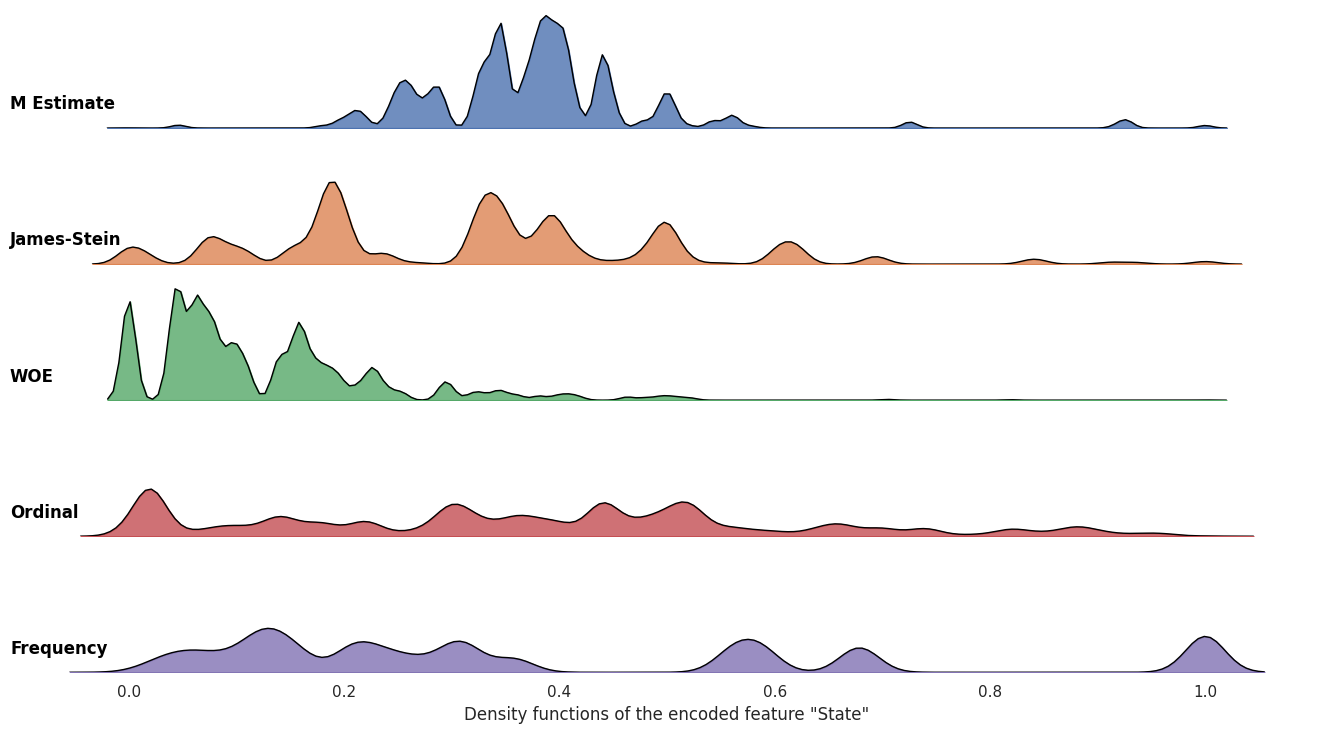

In [ ]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = sns.FacetGrid(plot_df, row="Encoder", hue="Encoder", aspect=9, height=1.5, palette="deep")

g.map_dataframe(sns.kdeplot, x="Value", fill=True, alpha=0.8)
g.map_dataframe(sns.kdeplot, x="Value", color='black', lw=1)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, 0.2, label, fontweight="bold", color='black',
                ha="left", va="center", transform=ax.transAxes)

g.map(label, "Value")

g.figure.subplots_adjust(hspace=-0.2)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

plt.xlabel('Density functions of the encoded feature "State"', fontsize=12)

plt.tight_layout()
plt.show()



--- Part 6: 特定組合下的特徵重要性分析 ---
為獲得總體重要性，將在完整數據集上重新訓練模型...

========================= 特徵重要性: CatBoost + Freq_encoder =========================
Top 20 最重要的特徵:
                             Feature  Importance      Encoder
                            cat__MCC   13.028693 Freq_encoder
                  cat__Merchant Name   10.728979 Freq_encoder
                       cat__Use Chip    9.357353 Freq_encoder
                  cat__Merchant City    6.322617 Freq_encoder
                num__is_in_home_city    6.240842 Freq_encoder
               num__is_in_home_state    5.749092 Freq_encoder
                 cat__Merchant State    5.472387 Freq_encoder
                         num__Amount    4.022137 Freq_encoder
                       num__hour_cos    3.738886 Freq_encoder
                       num__hour_sin    3.102407 Freq_encoder
                   num__Credit Limit    2.865339 Freq_encoder
                           cat__Card    2.776973 Freq_encoder
num__amount_to_personal_income_ratio

/tmp/ipython-input-36-825229946.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_features_df = combined_importance_df.groupby('Encoder').apply(lambda x: x.nlargest(10, 'Importance')).reset_index(drop=True)


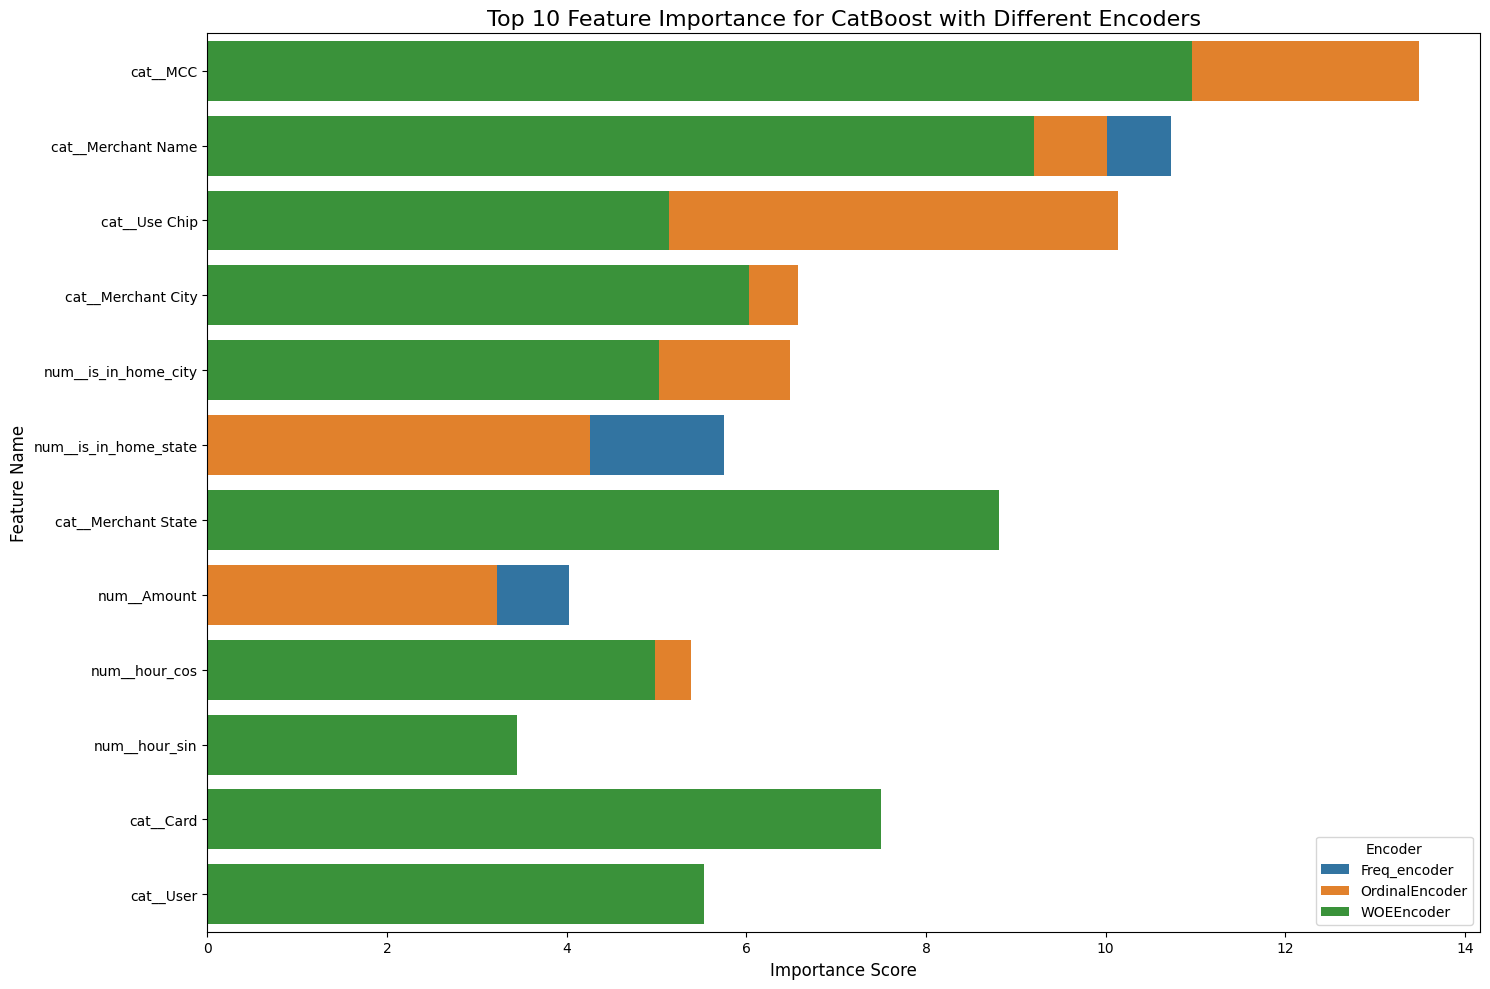

In [ ]:
print("Feature Important")

encoders_for_importance = {
    "Freq_encoder" : ce.CountEncoder(normalize=True),
    "OrdinalEncoder": ce.OrdinalEncoder(),
    "WOEEncoder": ce.WOEEncoder(),
}

if 'models_to_test' not in locals():
    print("without 'models_to_test'")
else:
    catboost_model_base = models_to_test['CatBoost']

    all_importance_dfs = []

    for encoder_name, encoder in encoders_for_importance.items():
        print(f"\nFeature Important: CatBoost + {encoder_name} {'='*25}")

        pipeline = Pipeline(steps=[
            ('preprocessor', ColumnTransformer(
                transformers=[
                    ('num', StandardScaler(), numerical_features),
                    ('cat', clone(encoder), categorical_features)
                ],
                remainder='passthrough'
            )),
            ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
            ('classifier', clone(catboost_model_base))
        ])

        pipeline.fit(X, y)

        try:
            feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

            importances = pipeline.named_steps['classifier'].feature_importances_

            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

            importance_df['Encoder'] = encoder_name
            all_importance_dfs.append(importance_df)

            print("Top 20:")
            print(importance_df.head(20).to_string(index=False))


if 'all_importance_dfs' in locals() and all_importance_dfs:
    combined_importance_df = pd.concat(all_importance_dfs, ignore_index=True)

    top_features_df = combined_importance_df.groupby('Encoder').apply(lambda x: x.nlargest(10, 'Importance')).reset_index(drop=True)

    plt.figure(figsize=(15, 10))
    sns.barplot(
        data=top_features_df,
        x='Importance',
        y='Feature',
        hue='Encoder',
        dodge=False
    )
    plt.title('Top 10 Feature Importance for CatBoost with Different Encoders', fontsize=16)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Feature Name', fontsize=12)
    plt.legend(title='Encoder')
    plt.tight_layout()
    plt.show()

# Strategy 1

In [ ]:
TARGET = 'Is Fraud?'
features_df = df_final.drop(columns=[TARGET], errors='ignore')
numerical_features = features_df.select_dtypes(include=np.number).columns.tolist()
categorical_features = features_df.select_dtypes(include=['object', 'category']).columns.tolist()

low_cardinality_features = [col for col in categorical_features if features_df[col].nunique() <= 15]
high_cardinality_features = [col for col in categorical_features if features_df[col].nunique() > 15]

X = df_final.drop(TARGET, axis=1)
y = df_final[TARGET]

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

high_cardinality_encoders = {
    "Ordinal": ce.OrdinalEncoder(handle_unknown='value', handle_missing='value'),
    "Frequency" : ce.CountEncoder(normalize=True, handle_unknown='value', handle_missing='value'),
    "WOE": ce.WOEEncoder(regularization=40, handle_unknown='value', handle_missing='value'),
    "JamesStein": ce.JamesSteinEncoder(model='binary', handle_unknown='value', handle_missing='value'),
    "MEstimate": ce.MEstimateEncoder(m=25),
}

models = {
    "XGBoost": (xgb.XGBClassifier, {'random_state': 335, 'eval_metric': 'aucpr', 'tree_method': 'hist', 'device': 'cuda'}),
    "CatBoost": (cb.CatBoostClassifier, {'random_state': 335, 'task_type': 'GPU', 'verbose': 0})
}

one_hot_encoder = ce.OneHotEncoder(handle_unknown='value', handle_missing='value', use_cat_names=True)

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring_metrics = {
    'pr_auc': 'average_precision',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}

results = []

for encoder_name, encoder in high_cardinality_encoders.items():
    for model_name, (model_class, model_params) in models.items():
        start_time = time.time()
        print(f"\n{encoder_name} + {model_name}...")

        fold_scores = []
        for fold, (train_idx, val_idx) in enumerate(cv_strategy.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            dynamic_scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
            current_model_params = model_params.copy()
            if model_name in ["XGBoost"]:
                current_model_params['scale_pos_weight'] = dynamic_scale_pos_weight
            current_model = model_class(**current_model_params)

            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', Pipeline([
                        ('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())
                    ]), numerical_features),
                    ('cat_low', one_hot_encoder, low_cardinality_features),
                    ('cat_high', Pipeline([
                        ('encoder', encoder),
                        ('scaler', StandardScaler())
                    ]), high_cardinality_features),
                ],
                remainder='passthrough'
            )

            pipeline = Pipeline(steps=[
                ('preprocessor', preprocessor),
                            ('classifier', current_model)
            ])

            X_train_to_fit = X_train
            y_train_to_fit = y_train

            pipeline.fit(X_train_to_fit, y_train_to_fit)

            pipeline.fit(X_train, y_train)
            y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
            precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_proba)
            f1_scores = np.divide(2 * precisions * recalls, precisions + recalls, out=np.zeros_like(precisions), where=(precisions + recalls) != 0)
            best_f1_idx = np.argmax(f1_scores)

            fold_scores.append({
                'PR AUC': average_precision_score(y_val, y_pred_proba),
                'Best F1-Score': f1_scores[best_f1_idx],
                'Best Threshold': thresholds[best_f1_idx] if best_f1_idx < len(thresholds) else 1.0,
                'Precision at Best F1': precisions[best_f1_idx],
                'Recall at Best F1': recalls[best_f1_idx]
            })

        duration = time.time() - start_time
        avg_scores = pd.DataFrame(fold_scores).mean().to_dict()

        results.append({
            "Encoder": encoder_name, "Model": model_name,
            "PR AUC": avg_scores['PR AUC'],
            "F1-Score": avg_scores['Best F1-Score'],
            "Precision": avg_scores['Precision at Best F1'],
            "Recall": avg_scores['Recall at Best F1'],
            "Duration (s)": duration
        })
        print(f"time: {duration:.2f} s, F1-Score: {avg_scores['Best F1-Score']:.4f}")


results_df = pd.DataFrame(results)
results_df.rename(columns={
    "F1-Score": "Best F1-Score",
    "Precision": "Precision at Best F1",
    "Recall": "Recall at Best F1"
}, inplace=True)
column_order = ['Encoder', 'Model', 'PR AUC', 'Best F1-Score', 'Precision at Best F1', 'Recall at Best F1', 'Duration (s)']
results_df_sorted = results_df[column_order].sort_values(by="Best F1-Score", ascending=False).reset_index(drop=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(results_df_sorted)



--- 開始手動交叉驗證評估 (採用穩健的預處理流程) ---

正在評估: Ordinal + XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:729: UserWarning: [18:15:51] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


完成。耗時: 202.40 秒, 平均 F1-Score: 0.6833

正在評估: Ordinal + CatBoost...
完成。耗時: 253.35 秒, 平均 F1-Score: 0.7278

正在評估: Frequency + XGBoost...
完成。耗時: 262.39 秒, 平均 F1-Score: 0.7014

正在評估: Frequency + CatBoost...
完成。耗時: 324.03 秒, 平均 F1-Score: 0.6664

正在評估: WOE + XGBoost...
完成。耗時: 243.68 秒, 平均 F1-Score: 0.7051

正在評估: WOE + CatBoost...
完成。耗時: 299.70 秒, 平均 F1-Score: 0.6971

正在評估: JamesStein + XGBoost...
完成。耗時: 248.96 秒, 平均 F1-Score: 0.5939

正在評估: JamesStein + CatBoost...
完成。耗時: 304.20 秒, 平均 F1-Score: 0.6034

正在評估: MEstimate + XGBoost...
完成。耗時: 243.56 秒, 平均 F1-Score: 0.4885

正在評估: MEstimate + CatBoost...
完成。耗時: 297.75 秒, 平均 F1-Score: 0.4726

--- 綜合性能比較表 (在各自最佳閥值下的5折交叉驗證平均值) ---
      Encoder     Model    PR AUC  Best F1-Score  Precision at Best F1  Recall at Best F1  Duration (s)
0     Ordinal  CatBoost  0.683876       0.727822              0.865664           0.628481    253.348110
1         WOE   XGBoost  0.688814       0.705065              0.843834           0.607145    243.679265
2   Frequency   X

# Strategy 2

In [ ]:
combined_encoders_to_test = {
    "WOE_plus_Frequency": FeatureUnion([
        ('woe_pipeline', Pipeline([('encoder', ce.WOEEncoder(regularization=40))])),
        ('freq_pipeline', Pipeline([('encoder', ce.CountEncoder(normalize=True))]))
    ]),
    "JS_plus_Frequency": FeatureUnion([
        ('js_pipeline', Pipeline([('encoder', ce.JamesSteinEncoder(model='binary'))])),
        ('freq_pipeline', Pipeline([('encoder', ce.CountEncoder(normalize=True))]))
    ]),
    "WOE_plus_Ordinal": FeatureUnion([
        ('woE_pipeline', Pipeline([('encoder', ce.WOEEncoder(regularization=40))])),
        ('ord_pipeline', Pipeline([('encoder', ce.OrdinalEncoder())]))
    ]),
    "JS_plus_Ordinal": FeatureUnion([
        ('js_pipeline', Pipeline([('encoder', ce.JamesSteinEncoder(model='binary'))])),
        ('ord_pipeline', Pipeline([('encoder', ce.OrdinalEncoder())]))
    ])
}

models_to_test = {
    "XGBoost": (xgb.XGBClassifier, {'random_state': 335, 'eval_metric': 'aucpr', 'tree_method': 'hist', 'device': 'cuda'}),
    "CatBoost": (cb.CatBoostClassifier, {'random_state': 335, 'task_type': 'GPU', 'verbose': 0})
}

all_results = []
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=335)
one_hot_encoder = ce.OneHotEncoder(handle_unknown='value', handle_missing='value', use_cat_names=True)

for encoder_name, combined_encoder in combined_encoders_to_test.items():
    for model_name, (model_class, model_params) in models_to_test.items():
        print(f"\n{encoder_name} + {model_name} {'='*25}")

        fold_results = []
        start_time = time.time()

        for fold, (train_idx, val_idx) in enumerate(cv_strategy.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            dynamic_scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
            current_model_params = model_params.copy()
            if model_name == "XGBoost":
                current_model_params['scale_pos_weight'] = dynamic_scale_pos_weight

            model = model_class(**current_model_params)

            # FeatureUnion
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', Pipeline([
                        ('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())
                    ]), numerical_features),

                    ('cat_low', one_hot_encoder, low_cardinality_features),

                    ('cat_high_combined', combined_encoder, high_cardinality_features)
                ],
                remainder='passthrough'
            )

            pipeline = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('classifier', model)
            ])

            pipeline.fit(X_train, y_train)
            y_pred_proba = pipeline.predict_proba(X_val)[:, 1]

            precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_proba)
            f1_scores = np.divide(2 * precisions * recalls, precisions + recalls, out=np.zeros_like(precisions), where=(precisions + recalls) != 0)
            best_f1_idx = np.argmax(f1_scores)

            fold_results.append({
                "PR AUC": average_precision_score(y_val, y_pred_proba),
                "Best F1-Score": f1_scores[best_f1_idx],
                "Precision at Best F1": precisions[best_f1_idx],
                "Recall at Best F1": recalls[best_f1_idx]
            })

        duration = time.time() - start_time
        avg_results = pd.DataFrame(fold_results).mean().to_dict()
        avg_results['Encoder_Combination'] = encoder_name
        avg_results['Model'] = model_name
        avg_results['Duration_s'] = duration
        all_results.append(avg_results)
        print(f"time: {duration:.2f} s, PR AUC: {avg_results['PR AUC']:.4f}, F1-Score: {avg_results['Best F1-Score']:.4f}")


print("\nResult: ")
results_df = pd.DataFrame(all_results)
column_order = ['Encoder_Combination', 'Model', 'PR AUC', 'Best F1-Score', 'Precision at Best F1', 'Recall at Best F1', 'Duration_s']
results_df_sorted = results_df[column_order].sort_values(by="PR AUC", ascending=False)
print(results_df_sorted.to_string(index=False))


--- Part 4: 開始執行組合編碼器的交叉驗證 ---

========================= 正在測試組合: WOE_plus_Frequency + XGBoost =========================
✅ 完成。耗時: 250.51 秒。 平均 PR AUC: 0.7206, 平均最佳 F1-Score: 0.7274

========================= 正在測試組合: WOE_plus_Frequency + CatBoost =========================
✅ 完成。耗時: 278.58 秒。 平均 PR AUC: 0.7220, 平均最佳 F1-Score: 0.7368

========================= 正在測試組合: JS_plus_Frequency + XGBoost =========================
✅ 完成。耗時: 255.16 秒。 平均 PR AUC: 0.5103, 平均最佳 F1-Score: 0.5356

========================= 正在測試組合: JS_plus_Frequency + CatBoost =========================
✅ 完成。耗時: 283.78 秒。 平均 PR AUC: 0.6534, 平均最佳 F1-Score: 0.6841

========================= 正在測試組合: WOE_plus_Ordinal + XGBoost =========================
✅ 完成。耗時: 199.55 秒。 平均 PR AUC: 0.7078, 平均最佳 F1-Score: 0.7319

========================= 正在測試組合: WOE_plus_Ordinal + CatBoost =========================
✅ 完成。耗時: 226.76 秒。 平均 PR AUC: 0.6993, 平均最佳 F1-Score: 0.7288

========================= 正在測試組合: JS_plus_Ordinal + XGBoost ==========

In [ ]:
def split_composite_errors(error_string: str) -> pd.Series:
    error_string = str(error_string).strip()
    if ',' in error_string:
        parts = error_string.split(',', 1)
        return pd.Series([parts[0].strip(), parts[1].strip()])
    else:
        return pd.Series([error_string, 'None'])

def create_final_feature_set_gnn(df: pd.DataFrame) -> pd.DataFrame:
    df_processed = df.copy()

    cols_to_clean_numeric = ['Credit Limit', 'Yearly Income - Person', 'Total Debt', 'Per Capita Income - Zipcode']
    for col in cols_to_clean_numeric:
        if col in df_processed.columns:
            df_processed[col] = pd.to_numeric(df_processed[col].astype(str).str.replace(r'[$,]', '', regex=True), errors='coerce')
    if 'Amount' in df_processed.columns:
        df_processed['Amount'] = df_processed['Amount'].abs()
    id_cols_to_str = ['User', 'Merchant Name', 'Zip', 'MCC', 'Card Brand', 'Card Type', 'Use Chip', 'Has Chip', 'State', 'Merchant State', 'Merchant City', 'City', 'Gender', 'Card on Dark Web']
    for col in id_cols_to_str:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].astype(str)
    if 'Errors?' in df_processed.columns:
        df_processed['Errors?'] = df_processed['Errors?'].fillna('No Error').astype(str)

    if all(c in df_processed.columns for c in ['Year', 'Month', 'Day', 'Time']):
        df_processed['trans_datetime'] = pd.to_datetime(df_processed[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1) + ' ' + df_processed['Time'], errors='coerce')
        df_processed['day_of_week_sin'] = np.sin(2 * np.pi * df_processed['trans_datetime'].dt.dayofweek / 7.0)
        df_processed['day_of_week_cos'] = np.cos(2 * np.pi * df_processed['trans_datetime'].dt.dayofweek / 7.0)
        df_processed['hour_sin'] = np.sin(2 * np.pi * df_processed['trans_datetime'].dt.hour / 24.0)
        df_processed['hour_cos'] = np.cos(2 * np.pi * df_processed['trans_datetime'].dt.hour / 24.0)
        if 'Acct Open Date' in df_processed.columns:
            acct_open_year = pd.to_datetime(df_processed['Acct Open Date'], format='%m/%Y', errors='coerce').dt.year
            df_processed['account_age_at_transaction'] = df_processed['Year'] - acct_open_year
    if 'State' in df_processed.columns and 'Merchant State' in df_processed.columns:
        df_processed['is_in_home_state'] = (df_processed['State'] == df_processed['Merchant State']).astype(int)
    if 'City' in df_processed.columns and 'Merchant City' in df_processed.columns:
        df_processed['is_in_home_city'] = (df_processed['City'] == df_processed['Merchant City']).astype(int)
    if 'Amount' in df_processed.columns and 'Credit Limit' in df_processed.columns:
        df_processed['amount_to_limit_ratio'] = df_processed['Amount'] / df_processed['Credit Limit'].replace(0, 1e-6)
    if 'Amount' in df_processed.columns and 'Yearly Income - Person' in df_processed.columns:
        df_processed['amount_to_personal_income_ratio'] = df_processed['Amount'] / df_processed['Yearly Income - Person'].replace(0, 1e-6)
    if 'Total Debt' in df_processed.columns and 'Yearly Income - Person' in df_processed.columns:
        df_processed['debt_to_income_ratio'] = df_processed['Total Debt'] / df_processed['Yearly Income - Person'].replace(0, 1e-6)
    if 'Amount' in df_processed.columns and 'Per Capita Income - Zipcode' in df_processed.columns:
        df_processed['amount_to_zip_income_ratio'] = df_processed['Amount'] / df_processed['Per Capita Income - Zipcode'].replace(0, 1e-6)
    if 'Errors?' in df_processed.columns:
        df_processed[['Error1_cat', 'Error2_cat']] = df_processed['Errors?'].apply(split_composite_errors)


    final_features_to_keep = [
        'Is Fraud?', 'User', 'Card', 'Amount', 'MCC', 'Card Brand', 'Card Type', 'Has Chip', 'Use Chip',
        'Cards Issued', 'Credit Limit', 'Current Age', 'Gender', 'FICO Score',
        'Num Credit Cards', 'Yearly Income - Person',
        'Merchant Name', 'Merchant State', 'Merchant City', 'State', 'City',
        'Total Debt',
        'Per Capita Income - Zipcode',
        'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos',
        'account_age_at_transaction',
        'is_in_home_state', 'is_in_home_city',
        'amount_to_limit_ratio', 'amount_to_personal_income_ratio',
        'debt_to_income_ratio', 'amount_to_zip_income_ratio',
        'Error1_cat', 'Error2_cat'
    ]

    final_cols_exist = [col for col in final_features_to_keep if col in df_processed.columns]
    df_final = df_processed[final_cols_exist].copy()

    for col in df_final.columns:
        if df_final[col].dtype.name in ['object', 'category']:
            df_final[col] = df_final[col].fillna('Unknown')
        else:
            df_final[col] = df_final[col].fillna(df_final[col].median())

    print(f"dim: {df_final.shape}")
    return df_final

In [ ]:
df_final = create_final_feature_set_gnn(df_full_context)

print("dim:", df_final.shape)
df_final.info()


--- 開始執行終極版特徵工程 ---
... 正在清理與轉換數據類型 ...
... 正在創建所有衍生特徵 ...
... 正在選擇最終特徵 ...
... 正在填充剩餘的缺失值 ...
✅ 特徵工程全部完成！最終資料維度: (1500000, 36)

--- 步驟 III: 最終成果檢查 ---
最終 DataFrame 維度: (1500000, 36)

最終 DataFrame 基本資訊:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500000 entries, 0 to 1499999
Data columns (total 36 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   Is Fraud?                        1500000 non-null  int64  
 1   User                             1500000 non-null  object 
 2   Card                             1500000 non-null  int64  
 3   Amount                           1500000 non-null  float64
 4   MCC                              1500000 non-null  object 
 5   Card Brand                       1500000 non-null  object 
 6   Card Type                        1500000 non-null  object 
 7   Has Chip                         1500000 non-null  object 
 8   Use Chip                         15000

In [ ]:
# ID
df_final['user_id'], user_uniques = pd.factorize(df_final['User'])
df_final['card_id'], card_uniques = pd.factorize(df_final['User'].astype(str) + '_' + df_final['Card'].astype(str))
df_final['merchant_id'], merchant_uniques = pd.factorize(df_final['Merchant Name'])

# City, State, MCC
all_cities = pd.concat([df_final['City'], df_final['Merchant City']]).unique()
all_states = pd.concat([df_final['State'], df_final['Merchant State']]).unique()
all_mccs = df_final['MCC'].unique()

city_map = {city: i for i, city in enumerate(all_cities)}
state_map = {state: i for i, state in enumerate(all_states)}
mcc_map = {mcc: i for i, mcc in enumerate(all_mccs)}

df_final['user_city_id'] = df_final['City'].map(city_map)
df_final['merchant_city_id'] = df_final['Merchant City'].map(city_map)
df_final['user_state_id'] = df_final['State'].map(state_map)
df_final['merchant_state_id'] = df_final['Merchant State'].map(state_map)
df_final['mcc_id'] = df_final['MCC'].map(mcc_map)


print("\nHeteroData")
graph_data = HeteroData()

graph_data['user'].num_nodes = len(user_uniques)
graph_data['card'].num_nodes = len(card_uniques)
graph_data['merchant'].num_nodes = len(merchant_uniques)
graph_data['city'].num_nodes = len(all_cities)
graph_data['state'].num_nodes = len(all_states)
graph_data['mcc'].num_nodes = len(all_mccs)

# user
user_num_features = ['Current Age', 'FICO Score', 'Num Credit Cards', 'Yearly Income - Person', 'Total Debt']
user_cat_features = ['Gender']
user_features_df = df_final.groupby('user_id')[user_num_features + user_cat_features].first()
user_preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), user_num_features),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), user_cat_features)
])
processed_user_features = user_preprocessor.fit_transform(user_features_df)
graph_data['user'].x = torch.tensor(processed_user_features, dtype=torch.float)

# card
card_num_features = ['Credit Limit', 'Cards Issued']
card_cat_features = ['Card Brand', 'Card Type', 'Has Chip']
card_features_df = df_final.groupby('card_id')[card_num_features + card_cat_features].first()
card_preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), card_num_features),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), card_cat_features)
])
processed_card_features = card_preprocessor.fit_transform(card_features_df)
graph_data['card'].x = torch.tensor(processed_card_features, dtype=torch.float)


print("\nEdge Index")

# user-card
user_card_edges = df_final[['user_id', 'card_id']].drop_duplicates()
edge_index_user_owns_card = torch.tensor(user_card_edges.values.T, dtype=torch.long)
graph_data['user', 'owns', 'card'].edge_index = edge_index_user_owns_card
graph_data['card', 'owned_by', 'user'].edge_index = edge_index_user_owns_card[[1, 0]]

# card-merchant
card_merchant_edges = df_final[['card_id', 'merchant_id']]
edge_index_card_interacts_merchant = torch.tensor(card_merchant_edges.values.T, dtype=torch.long)
graph_data['card', 'interacts_with', 'merchant'].edge_index = edge_index_card_interacts_merchant
graph_data['merchant', 'rev_interacts_with', 'card'].edge_index = edge_index_card_interacts_merchant[[1, 0]]

# user-city
user_city_edges = df_final[['user_id', 'user_city_id']].drop_duplicates()
edge_index_user_lives_in_city = torch.tensor(user_city_edges.values.T, dtype=torch.long)
graph_data['user', 'lives_in', 'city'].edge_index = edge_index_user_lives_in_city
graph_data['city', 'hosts_user', 'user'].edge_index = edge_index_user_lives_in_city[[1, 0]]

# merchant-city
merchant_city_edges = df_final[['merchant_id', 'merchant_city_id']].drop_duplicates()
edge_index_merchant_in_city = torch.tensor(merchant_city_edges.values.T, dtype=torch.long)
graph_data['merchant', 'located_in', 'city'].edge_index = edge_index_merchant_in_city
graph_data['city', 'hosts_merchant', 'merchant'].edge_index = edge_index_merchant_in_city[[1, 0]]

# city-state
city_state_map_df = pd.concat([
    df_final[['user_city_id', 'user_state_id']].rename(columns={'user_city_id': 'city_id', 'user_state_id': 'state_id'}),
    df_final[['merchant_city_id', 'merchant_state_id']].rename(columns={'merchant_city_id': 'city_id', 'merchant_state_id': 'state_id'})
]).drop_duplicates().dropna()
edge_index_city_in_state = torch.tensor(city_state_map_df.values.T, dtype=torch.long)
graph_data['city', 'part_of', 'state'].edge_index = edge_index_city_in_state
graph_data['state', 'contains', 'city'].edge_index = edge_index_city_in_state[[1, 0]]

# merchant-MCC
merchant_mcc_edges = df_final[['merchant_id', 'mcc_id']].drop_duplicates()
edge_index_merchant_has_mcc = torch.tensor(merchant_mcc_edges.values.T, dtype=torch.long)
graph_data['merchant', 'has_category', 'mcc'].edge_index = edge_index_merchant_has_mcc
graph_data['mcc', 'is_category_of', 'merchant'].edge_index = edge_index_merchant_has_mcc[[1, 0]]

# Transaction edge

edge_numeric_cols = ['Amount', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos']
edge_categorical_cols = ['Use Chip', 'Error1_cat', 'Error2_cat']

edge_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), edge_numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), edge_categorical_cols)
    ],
    remainder='drop'
)

edge_feature_source_cols = edge_numeric_cols + edge_categorical_cols
processed_edge_features = edge_preprocessor.fit_transform(df_final[edge_feature_source_cols])

# Transaction edge card-merchant
graph_data['card', 'interacts_with', 'merchant'].edge_attr = torch.tensor(processed_edge_features, dtype=torch.float)

print(f"dim: {processed_edge_features.shape[1]}")

print("Structure")
print(graph_data)

--- 步驟 1: 為所有節點類型創建統一且唯一的數字 ID 映射 ---
✅ 節點 ID 創建完成！

--- 步驟 2: 初始化 HeteroData 對象並定義節點與其特徵 ---
... 正在為 'user' 節點準備特徵 ...
... 正在為 'card' 節點準備特徵 ...
✅ 節點定義與特徵添加完成！

--- 步驟 3: 創建所有邊索引 (Edge Index) - 包含反向邊 ---
✅ 所有邊關係（包括反向邊）創建完成！

--- 步驟 4: 為交易邊添加增強版特徵 ---
✅ 邊特徵添加完成！最終邊特徵維度: 21

--- 步驟 5: 最終圖數據結構預覽 ---
HeteroData(
  user={
    num_nodes=1991,
    x=[1991, 7],
  },
  card={
    num_nodes=5974,
    x=[5974, 11],
  },
  merchant={ num_nodes=39129 },
  city={ num_nodes=10258 },
  state={ num_nodes=191 },
  mcc={ num_nodes=109 },
  (user, owns, card)={ edge_index=[2, 5974] },
  (card, owned_by, user)={ edge_index=[2, 5974] },
  (card, interacts_with, merchant)={
    edge_index=[2, 1500000],
    edge_attr=[1500000, 21],
  },
  (merchant, rev_interacts_with, card)={ edge_index=[2, 1500000] },
  (user, lives_in, city)={ edge_index=[2, 1991] },
  (city, hosts_user, user)={ edge_index=[2, 1991] },
  (merchant, located_in, city)={ edge_index=[2, 99907] },
  (city, hosts_merchant, merchant)={ edge_inde

In [ ]:
class HeteroGNN_Refactored(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, node_types, edge_types, node_feature_dims, dropout_rate=0.5):
        super().__init__()

        self.embeddings = torch.nn.ModuleDict()
        self.linears = torch.nn.ModuleDict()
        self.batch_norms = torch.nn.ModuleDict()
        for node_type in node_types:
            if node_type not in node_feature_dims:
                num_nodes = graph_data[node_type].num_nodes
                self.embeddings[node_type] = torch.nn.Embedding(num_nodes, hidden_channels)
            self.batch_norms[node_type] = BatchNorm(hidden_channels)

        for node_type, dim in node_feature_dims.items():
            self.linears[node_type] = Linear(dim, hidden_channels)

        self.conv1 = HeteroConv({
            edge_type: SAGEConv((-1, -1), hidden_channels) for edge_type in edge_types
        }, aggr='sum')

        self.conv2 = HeteroConv({
            edge_type: SAGEConv((-1, -1), out_channels) for edge_type in edge_types
        }, aggr='sum')

        self.dropout = torch.nn.Dropout(dropout_rate)

    def forward(self, x_dict, edge_index_dict):

        x_dict_processed = {}
        for node_type, x in x_dict.items():
            if node_type in self.linears:
                x = self.linears[node_type](x)
            else:
                x = self.embeddings[node_type](x)
            x = self.batch_norms[node_type](x).relu()
            x_dict_processed[node_type] = x

        x_dict = self.conv1(x_dict_processed, edge_index_dict)
        x_dict = {key: self.dropout(x.relu()) for key, x in x_dict.items()}

        x_dict = self.conv2(x_dict, edge_index_dict)

        return x_dict

# GNN
train_graph = graph_data

node_feature_dims = {}
for node_type in graph_data.node_types:
    if hasattr(graph_data[node_type], 'x') and graph_data[node_type].x is not None:
        node_feature_dims[node_type] = graph_data[node_type].x.shape[1]

gnn_model = HeteroGNN_Refactored(
    hidden_channels=256,
    out_channels=128,
    node_types=graph_data.node_types,
    edge_types=train_graph.edge_types,
    node_feature_dims=node_feature_dims,
    dropout_rate=0.5
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gnn_model = gnn_model.to(device)

print(gnn_model)

# train

edge_label_index = train_graph['card', 'interacts_with', 'merchant'].edge_index
train_loader = LinkNeighborLoader(
    data=train_graph,
    num_neighbors=[20, 10],
    edge_label_index=(('card', 'interacts_with', 'merchant'), edge_label_index),
    neg_sampling_ratio=3.0,
    batch_size=2048,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

# optimizer
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, min_lr=0.00001)

# training
start_time = time.time()

for epoch in range(1, 11):
    total_loss = 0
    total_examples = 0
    gnn_model.train()

    for batch in tqdm(train_loader, desc=f'Epoch {epoch:02d}'):
        batch = batch.to(device)
        optimizer.zero_grad()

        x_dict_input = {
            node_type: batch[node_type].x if hasattr(batch[node_type], 'x') else batch[node_type].n_id
            for node_type in batch.node_types
        }
        z_dict = gnn_model(x_dict_input, batch.edge_index_dict)

        edge_label_index = batch['card', 'interacts_with', 'merchant'].edge_label_index
        edge_label = batch['card', 'interacts_with', 'merchant'].edge_label

        src_emb = z_dict['card'][edge_label_index[0]]
        dst_emb = z_dict['merchant'][edge_label_index[1]]

        pred = (src_emb * dst_emb).sum(dim=-1)
        loss = F.binary_cross_entropy_with_logits(pred, edge_label)

        loss.backward()
        optimizer.step()

        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()

    avg_loss = total_loss / total_examples
    scheduler.step(avg_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch}, Avg Loss: {avg_loss:.4f}")

total_duration = time.time() - start_time
print(f"\nTime: {total_duration:.2f} s")


--- 步驟 2: 實例化 GNN 模型 ---
將使用設備: cuda
HeteroGNN_Refactored(
  (embeddings): ModuleDict(
    (merchant): Embedding(39129, 256)
    (city): Embedding(10258, 256)
    (state): Embedding(191, 256)
    (mcc): Embedding(109, 256)
  )
  (linears): ModuleDict(
    (user): Linear(7, 256, bias=True)
    (card): Linear(11, 256, bias=True)
  )
  (batch_norms): ModuleDict(
    (user): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (card): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (merchant): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (city): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (state): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (mcc): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1): HeteroConv(num_relations=12)
  (conv2): HeteroConv(num_relations=12)
  (

Epoch 01:   0%|          | 0/733 [00:00<?, ?it/s]

--- Epoch 1 完成, 平均 Loss: 0.3495, 目前學習率: 0.001


Epoch 02:   0%|          | 0/733 [00:00<?, ?it/s]

--- Epoch 2 完成, 平均 Loss: 0.1098, 目前學習率: 0.001


Epoch 03:   0%|          | 0/733 [00:00<?, ?it/s]

--- Epoch 3 完成, 平均 Loss: 0.0867, 目前學習率: 0.001


Epoch 04:   0%|          | 0/733 [00:00<?, ?it/s]

--- Epoch 4 完成, 平均 Loss: 0.0763, 目前學習率: 0.001


Epoch 05:   0%|          | 0/733 [00:00<?, ?it/s]

--- Epoch 5 完成, 平均 Loss: 0.0695, 目前學習率: 0.001


Epoch 06:   0%|          | 0/733 [00:00<?, ?it/s]

--- Epoch 6 完成, 平均 Loss: 0.0653, 目前學習率: 0.001


Epoch 07:   0%|          | 0/733 [00:00<?, ?it/s]

--- Epoch 7 完成, 平均 Loss: 0.0626, 目前學習率: 0.001


Epoch 08:   0%|          | 0/733 [00:00<?, ?it/s]

--- Epoch 8 完成, 平均 Loss: 0.0604, 目前學習率: 0.001


Epoch 09:   0%|          | 0/733 [00:00<?, ?it/s]

--- Epoch 9 完成, 平均 Loss: 0.0586, 目前學習率: 0.001


Epoch 10:   0%|          | 0/733 [00:00<?, ?it/s]

--- Epoch 10 完成, 平均 Loss: 0.0568, 目前學習率: 0.001

✅ GNN 模型訓練完成！總耗時: 383.26 秒


In [ ]:
gnn_model.eval()
gnn_model = gnn_model.to('cpu')
graph_data = graph_data.to('cpu')

with torch.no_grad():
    full_x_dict_input = {
        node_type: graph_data[node_type].x if hasattr(graph_data[node_type], 'x') else torch.arange(graph_data[node_type].num_nodes)
        for node_type in graph_data.node_types
    }
    final_embeddings = gnn_model(full_x_dict_input, graph_data.edge_index_dict)

user_embeddings = final_embeddings['user'].numpy()
merchant_embeddings = final_embeddings['merchant'].numpy()

user_emb_df = pd.DataFrame(user_embeddings, columns=[f'user_emb_{i}' for i in range(user_embeddings.shape[1])])
user_emb_df['User'] = user_uniques
merchant_emb_df = pd.DataFrame(merchant_embeddings, columns=[f'merchant_emb_{i}' for i in range(merchant_embeddings.shape[1])])
merchant_emb_df['Merchant Name'] = merchant_uniques

df_augmented = pd.merge(df_final, user_emb_df, on='User', how='left')
df_augmented = pd.merge(df_augmented, merchant_emb_df, on='Merchant Name', how='left')
print(f"Dim: {df_augmented.shape}")

TARGET = 'Is Fraud?'
cols_to_drop = [TARGET, 'User', 'Card', 'Merchant Name', 'MCC', 'Errors?', 'Card Brand', 'Card Type', 'Has Chip', 'Use Chip', 'Gender', 'Merchant State', 'Merchant City', 'State', 'City', 'Error1_cat', 'Error2_cat']
cols_to_drop_exist = [col for col in cols_to_drop if col in df_augmented.columns]
X_aug = df_augmented.drop(columns=cols_to_drop_exist)
y_aug = df_augmented[TARGET]

models_to_test = {
    "DecisionTree_GNN": (DecisionTreeClassifier, {'random_state': 335, 'class_weight': 'balanced'}),
    "RandomForest_GNN": (RandomForestClassifier, {'random_state': 335, 'n_jobs': -1, 'class_weight': 'balanced'}),
    "XGBoost_GNN": (xgb.XGBClassifier, {'random_state': 335, 'eval_metric': 'aucpr', 'tree_method': 'hist', 'device': 'cuda'}),
    "CatBoost_GNN": (cb.CatBoostClassifier, {'random_state': 335, 'task_type': 'GPU',  'verbose': 0}),
}
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_model_results = {}

for model_name, (model_class, model_params) in models_to_test.items():
    print(f"\n{model_name}")
    all_fold_results = []
    for fold, (train_idx, val_idx) in enumerate(tqdm(cv_strategy.split(X_aug, y_aug), total=5, desc=f"({model_name})")):
        X_train, X_val = X_aug.iloc[train_idx], X_aug.iloc[val_idx]
        y_train, y_val = y_aug.iloc[train_idx], y_aug.iloc[val_idx]

        dynamic_scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
        current_model_params = model_params.copy()
        if model_name in ["XGBoost_GNN"]:
            current_model_params['scale_pos_weight'] = dynamic_scale_pos_weight

        current_model = model_class(**current_model_params)

        pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('classifier', current_model)])
        pipeline.fit(X_train, y_train)

        y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_proba)
        fscores = np.divide(2 * precisions * recalls, precisions + recalls, out=np.zeros_like(precisions), where=(precisions + recalls) != 0)
        ix = np.argmax(fscores)
        best_threshold = thresholds[ix] if ix < len(thresholds) else 1.0
        y_pred_class_optimal = (y_pred_proba >= best_threshold).astype(int)

        fold_scores = {
            'PR AUC': average_precision_score(y_val, y_pred_proba),
            'F1-Score': f1_score(y_val, y_pred_class_optimal, zero_division=0),
            'Precision': precision_score(y_val, y_pred_class_optimal, zero_division=0),
            'Recall': recall_score(y_val, y_pred_class_optimal, zero_division=0),
            'Optimal Threshold': best_threshold
        }
        all_fold_results.append(fold_scores)

    results_df = pd.DataFrame(all_fold_results)
    all_model_results[model_name] = results_df.agg(['mean', 'std'])


for model_name, summary_df in all_model_results.items():
    print(f"\n{model_name}")
    print(summary_df)


--- Part 4: 提取嵌入並增強特徵 ---
✅ 節點嵌入提取完成！
✅ 特徵增強完成！新的 DataFrame 維度: (1500000, 300)

--- Part 5: 使用 GNN 增強特徵進行交叉驗證 ---

[模型評估]: DecisionTree_GNN


交叉驗證 (DecisionTree_GNN):   0%|          | 0/5 [00:00<?, ?it/s]


[模型評估]: RandomForest_GNN


交叉驗證 (RandomForest_GNN):   0%|          | 0/5 [00:00<?, ?it/s]


[模型評估]: XGBoost_GNN


交叉驗證 (XGBoost_GNN):   0%|          | 0/5 [00:00<?, ?it/s]


[模型評估]: CatBoost_GNN


交叉驗證 (CatBoost_GNN):   0%|          | 0/5 [00:00<?, ?it/s]



    GNN 增強模型交叉驗證最終性能報告

--- DecisionTree_GNN (5折交叉驗證平均值與標準差) ---
        PR AUC  F1-Score  Precision    Recall  Optimal Threshold
mean  0.368663  0.604548   0.649757  0.565661                1.0
std   0.036937  0.031597   0.027678  0.037634                0.0

--- RandomForest_GNN (5折交叉驗證平均值與標準差) ---
        PR AUC  F1-Score  Precision    Recall  Optimal Threshold
mean  0.680329  0.707689   0.839119  0.612339           0.212000
std   0.010710  0.010428   0.024901  0.016636           0.032711

--- XGBoost_GNN (5折交叉驗證平均值與標準差) ---
        PR AUC  F1-Score  Precision    Recall  Optimal Threshold
mean  0.734507  0.762025   0.904580  0.658410           0.928016
std   0.007563  0.005051   0.016902  0.005199           0.021573

--- CatBoost_GNN (5折交叉驗證平均值與標準差) ---
        PR AUC  F1-Score  Precision    Recall  Optimal Threshold
mean  0.732227  0.777522   0.939357  0.663601           0.288298
std   0.011296  0.011871   0.019323  0.018111           0.052796


✅ 所有模型交叉驗證流程執行完畢！
